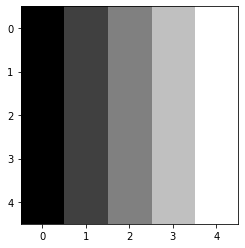

In [1]:
import matplotlib.pyplot as plt
import numpy as np

test = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
plt.imshow(test, cmap="gray")
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from cv import Cadence
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import ReLU, Conv2d, MaxPool2d, BatchNorm2d

### Config

In [3]:
conf_dict = {
    "batch_size": 32,
    "learn_rate": 1e-3,
    "epochs": 5,

    "train_dir": "../data/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../data/test/",
    "test_csv": "sample_submission.csv",
    "height": 512,
    "width": 512,

    "origin_height": 273,
    "origin_width": 256,

    "random_seed": 10,

    "only_use": 1000,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


### Custom Dataset

In [4]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, img_dir, test=False, transform=None, target_transform=None, use_cv=False):
		self.test = test
		if not self.test:
			self.img_labels = pd.read_csv(img_dir + conf_dict["train_csv"])
		else:
			self.img_labels = pd.read_csv(img_dir + conf_dict["test_csv"])
		self.img_labels['file_path'] = self.img_labels['id'].apply(self.get_file_path, dir=img_dir)
		self.img_dir = img_dir
		self.file_names = self.img_labels['file_path'].values
		self.transform = transform
		self.target_transform = target_transform
		self.use_cv = use_cv

	def __len__(self):
		return len(self.img_labels)

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		if self.use_cv:
			cadence = Cadence(file_path)
			cadence.cv()

		image = np.vstack(image).T

		if self.transform:
			image = self.transform(image=image)['image']
		else:
			image = image[np.newaxis,:,:] # add dimension
			image = torch.from_numpy(image).float()

		label = torch.tensor(self.img_labels["target"][idx])#.float()
		return image, label

	def get_file_path(self, image_id, dir):
		return dir + "{}/{}.npy".format(image_id[0], image_id)


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = self.linear_relu()
        self.simple_cnn_stack = self.cnn_layers()

    def forward(self, x):
        x = self.simple_cnn_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

    def linear_relu(self):
        return nn.Sequential(
            nn.Linear(4 * 128 * 128, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def cnn_layers(self):
        return nn.Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

In [6]:
class SETITrainValidation():
    def __init__(self, train_dir, test_dir, model, loss_fn, optimizer, val_split=0.25):
        self.dataset_whole_train = SETIDataset(train_dir, transform=self.get_transforms(data="train"))#, use_cv=True)
        self.dataset_whole_val = SETIDataset(train_dir, transform=self.get_transforms(data="val"))#, use_cv=True) # extra dataset für validation, da validation data nicht transformiert werden darf
        # self.dataset_test = SETIDataset(test_dir, test=True, transform=self.get_transforms(data="test"), use_cv=True)
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.val_split = val_split
        self.train_dataloader = None
        self.val_dataloader = None

    def get_transforms(self, data):
        if data == 'train':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                A.VerticalFlip(p = 0.5),
                A.HorizontalFlip(p = 0.5),
                ToTensorV2()
            ])
        elif data == 'val' or data == 'test':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                ToTensorV2()
            ])

    def split(self, shuffle=True, use_all=True):
        dataset_whole_size = len(self.dataset_whole_train)
        if use_all:
            indices = list(range(dataset_whole_size))
            split = int(np.floor(self.val_split * dataset_whole_size))
        else:
            indices = list(range(conf_dict["only_use"]))
            split = int(np.floor(self.val_split * conf_dict["only_use"]))

        if shuffle:
            np.random.seed(conf_dict["random_seed"])
            np.random.shuffle(indices)

        train_indices, val_indices = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        self.train_dataloader = DataLoader(self.dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)#, num_workers=2)
        self.val_dataloader = DataLoader(self.dataset_whole_val, batch_size=conf_dict["batch_size"], sampler=val_sampler)#, num_workers=2)

        print(f"Successfully splitted dataset!\n Trainbatches: {len(self.train_dataloader)}\n Validationbatches: {len(self.val_dataloader)}")
    
    def train_loop(self):
        print("Starting model training...")
        size = len(self.train_dataloader.dataset)
        num_batches = len(self.train_dataloader)
        for batch, (image, label) in enumerate(self.train_dataloader):
            # print(f"batch {batch}/{num_batches}")
            image = image.to(device)
            label = label.to(device)
            pred = model(image)
            loss = loss_fn(pred, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def validation_loop(self):
        print("Starting model validation...")
        size = len(self.val_dataloader.dataset)
        num_batches = len(self.val_dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for batch, (image, label) in enumerate(self.val_dataloader):
                # print(f"batch {batch}/{num_batches}")
                image = image.to(device)
                label = label.to(device)
                pred = model(image)
                test_loss += loss_fn(pred, label).item()
                correct += (pred.argmax(1) == label).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"])
seti_trainer = SETITrainValidation(conf_dict["train_dir"], conf_dict["test_dir"], model, loss_fn, optimizer)
seti_trainer.split(use_all=True)
num_epochs = conf_dict["epochs"]

for t in range(num_epochs):
    print(f"Epoch {t+1}/{num_epochs}\n-------------------------------")
    seti_trainer.train_loop()
    seti_trainer.validation_loop()
print("Done!")
print("Saving model...")
torch.save(model.state_dict(), "schnaufnet_trained.pth")
print("Saved model")

Successfully splitted dataset!
 Trainbatches: 1407
 Validationbatches: 469
Epoch 1/5
-------------------------------
Starting model training...
loss: 2.163560  [    0/60000]


KeyboardInterrupt: 